<a href="https://colab.research.google.com/github/Anjalikhillare/Time-Series-Forecasting/blob/main/Time_series_forecasting_milk_production_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TIME SERIES FORECASTING**

For the dataset given

1. Comment on the nature of the data using suitable
visualization techniques
2.Check the stationary using ADF test
and autocorrelation plot.
3. Forecast the target variable prediction using a suitable
type of model
4.Evaluate the different types of errorresidues to
check fitness of good of the model.
5. Forecast the predictions for next 5 years on target variable.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

!pip install pmdarima --quiet
import pmdarima as pm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Analytics/monthly_milk_production.csv', parse_dates = ['Date'], index_col = 'Date')

In [ ]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [ ]:
df.tail()

,Production
Date,
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797
1975-12-01,843


In [ ]:
df.shape

(168, 1)

In [ ]:
df.describe()

,Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [ ]:
df.isna().sum()

Production    0
dtype: int64

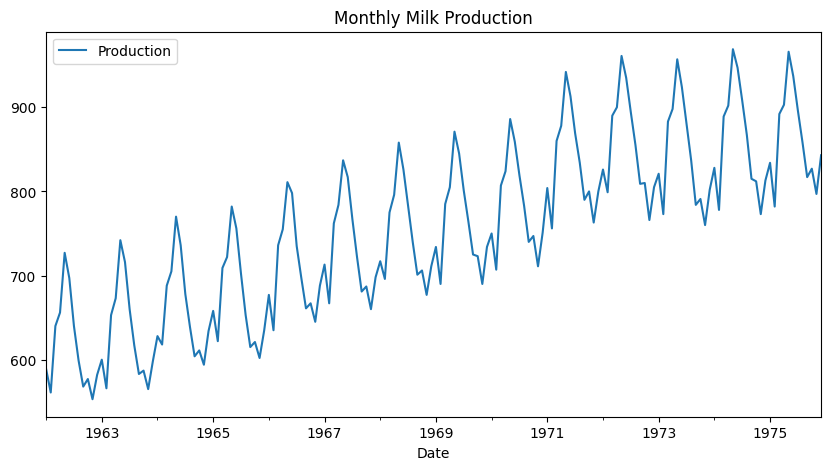

In [ ]:
df.plot(figsize = (10,5))
plt.title('Monthly Milk Production')
plt.show()

We can see that our data have a rising trend and very strong seasonality.

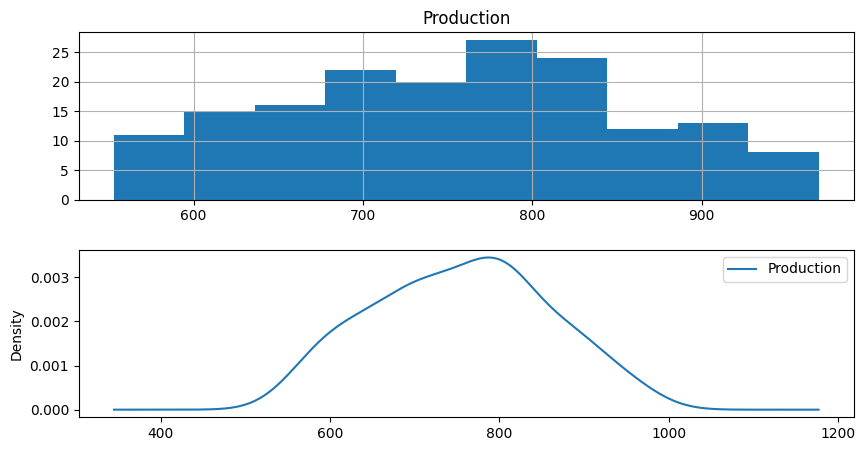

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))
df.hist(ax = ax1)
df.plot(kind = 'kde', ax = ax2)
plt.show()

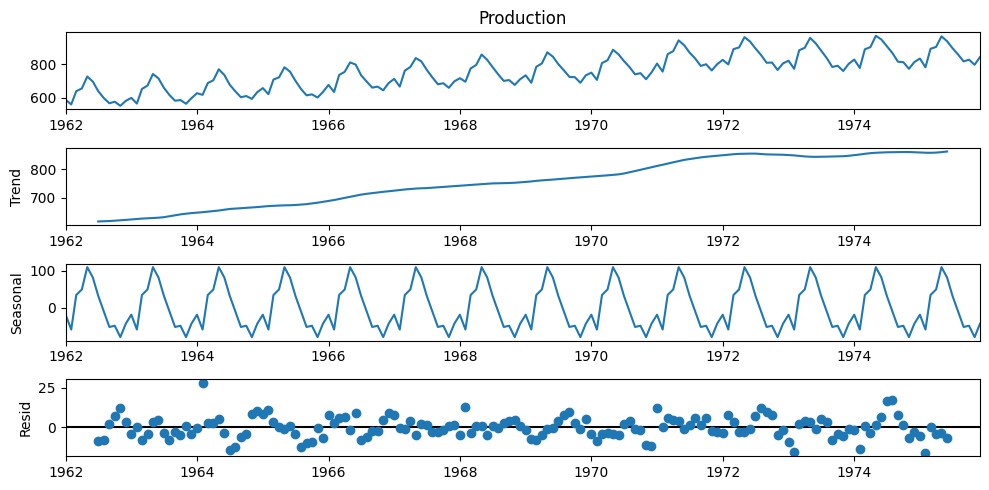

In [ ]:
decomposition = seasonal_decompose(df['Production'], period = 12, model = 'additive')
plt.rcParams['figure.figsize'] = 10, 5
decomposition.plot()
plt.show()

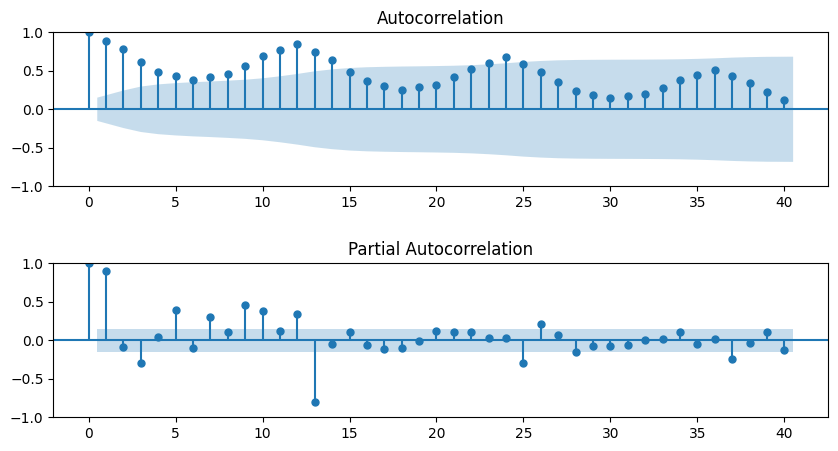

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = plot_acf(df['Production'], lags = 40, ax = ax1)
ax2 = plot_pacf(df['Production'], lags = 40, ax = ax2)

plt.subplots_adjust(hspace = 0.5)
plt.show()

It can be observed that the time series is not stationary because neither the ACF nor the PACF plots exhibit a sharp cut off into the 95% confidence interval area (in blue).

**ADF Test**

Augmented Dickey-Fuller Test - to check the stationality of data:

Null Hypothesis: Unit root exists, time series is not stationary

Alternate Hypothesis: Unit root does not exist, time series is stationary

In [ ]:
def adfuller_test(production):
    result = adfuller(production)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis:REJECT Ho. and the series is Stationary')
    else:
        print('Weak evidence against null hypothesis: ACCEPT Ho. and the series is Not Stationary.')

In [ ]:
adfuller_test(df['Production'])

ADF Test Statistic: -1.3038115874221308
p-value: 0.6274267086030311
#Lags Used: 13
#Observation Used: 154
Weak evidence against null hypothesis: ACCEPT Ho. and the series is Not Stationary.


In [ ]:
df1 = df.diff().diff(12).dropna()

By dropping the earlier observations from the present observations, we can use differencing to render time series stationary. By doing this, we will get rid of seasonality and trends and stabilise the mean of the time series. We use one non-seasonal diff() and one seasonal differencing diff(12) due to trend and seasonal components.

In [ ]:
adfuller_test(df1['Production'])

ADF Test Statistic: -5.038002274921981
p-value: 1.865423431878848e-05
#Lags Used: 11
#Observation Used: 143
Strong evidence against the null hypothesis:REJECT Ho. and the series is Stationary


Negative ADF Statistics Value

P-value is below 0.05.

This supports the alternate hypothesis of the ADF Test, which states that there is no unit root and that time series are stationary.

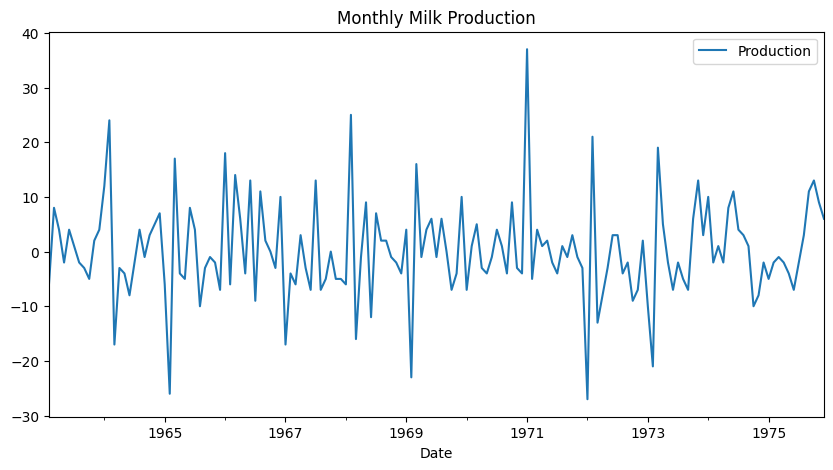

In [ ]:
df1.plot(figsize=(10,5))
plt.title('Monthly Milk Production')
plt.show()

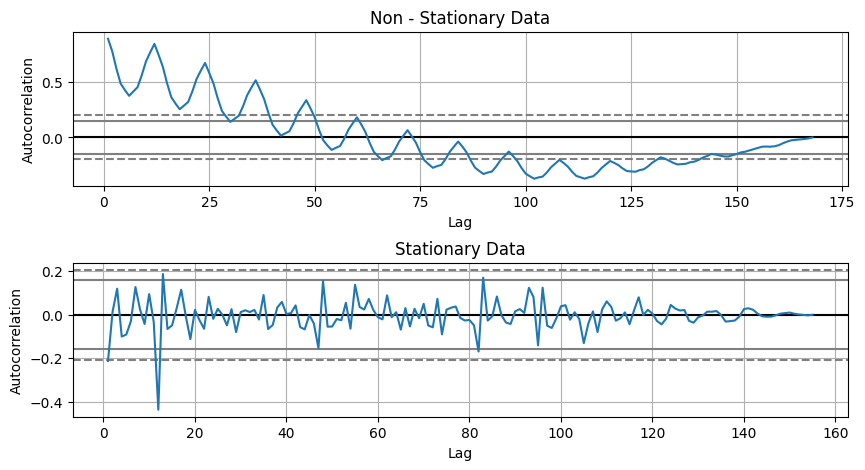

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = autocorrelation_plot(df['Production'], ax = ax1)
ax1.set_title('Non - Stationary Data')

ax2 = autocorrelation_plot(df1['Production'], ax = ax2)
ax2.set_title('Stationary Data')

plt.subplots_adjust(hspace = 0.5)
plt.show()

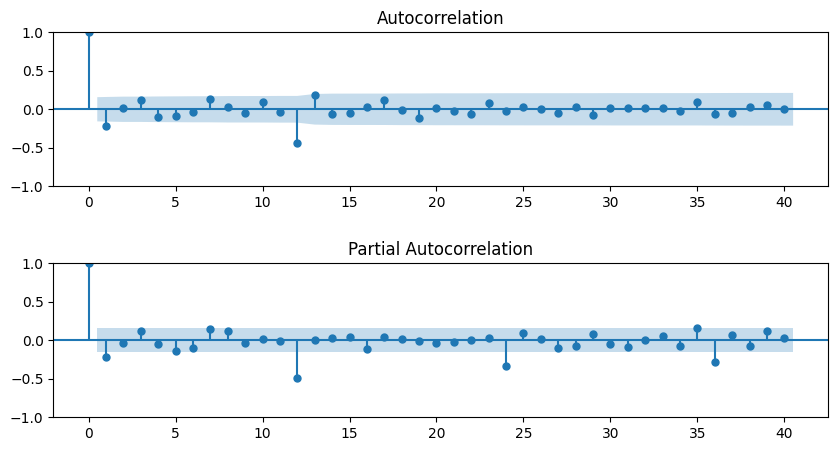

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = plot_acf(df1['Production'], lags = 40, ax = ax1)
ax2 = plot_pacf(df1['Production'], lags = 40, ax = ax2)

plt.subplots_adjust(hspace = 0.5)
plt.show()

Model Parameter Estimation

In [ ]:
model = pm.auto_arima(df['Production'], d = 1, D = 1,
                      seasonal = True, m = 12,
                      start_p = 0, start_q = 0, max_order = 6, test = 'adf', trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1074.131, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1119.969, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1081.584, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1066.296, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1114.995, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1068.030, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1067.976, Time=0.91 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1082.123, Time=0.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=5.97 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1072.280, Time=0.38 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1068.064, Time=0.74 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1067.796, Time=0.40 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1066.207, Time=0.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1114.845, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Wed, 26 Jul 2023   AIC                           1066.207
Time:                                      08:49:36   BIC                           1075.337
Sample:                                  01-01-1962   HQIC                          1069.916
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.077     -2.925      0.003      -0.376      -0.074
ma.S.L12      -0.6190      0.070     -8.825      0.000      -0.757      -0.482
sigma2        52.6908      4.897     10.759      0.000      43.093      62.289
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.74
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

train.shape, test.shape

((142, 1), (26, 1))

In [ ]:
model = SARIMAX(train['Production'],
                order = (1,1,0), seasonal_order = (0,1,1,12))
results = model.fit(disp = False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Production   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -445.603
Date:                              Wed, 26 Jul 2023   AIC                            897.205
Time:                                      08:50:18   BIC                            905.785
Sample:                                  01-01-1962   HQIC                           900.691
                                       - 10-01-1973                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2728      0.087     -3.149      0.002      -0.443      -0.103
ma.S.L12      -0.6158      0.086     -7.163      0.000      -0.784      -0.447
sigma2        56.0243      5.765      9.719      0.000      44.726      67.323
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                40.04
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.86
Prob(H) (two-sided):                  0.71   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model Validation

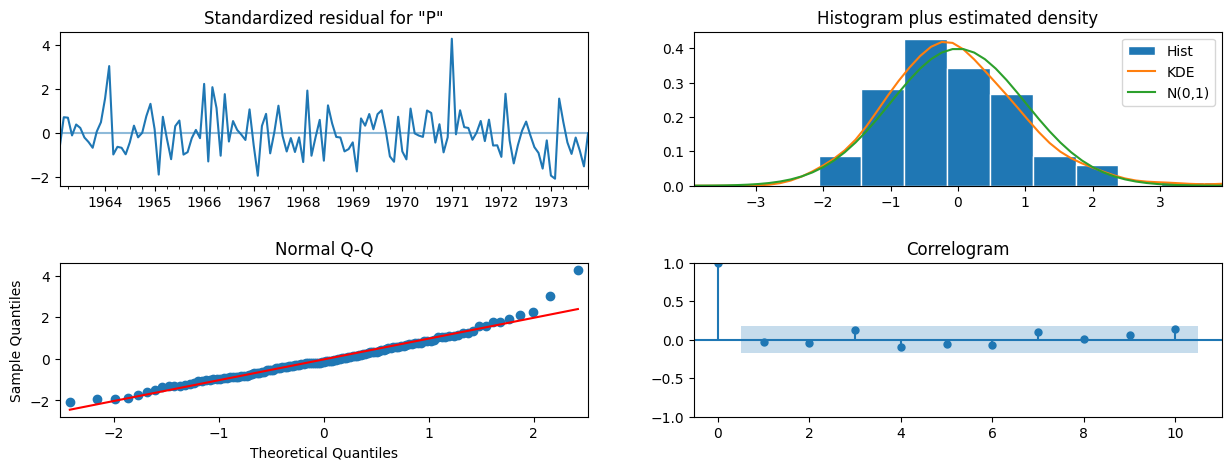

In [ ]:
results.plot_diagnostics(figsize = (15, 5))
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA(1,1,0)(0,1,1,12) Test Predictions')

In [ ]:
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]:<11.10}, expected = {test['Production'][i]}")

predicted = 752.7789608, expected = 760
predicted = 791.7112655, expected = 802
predicted = 816.6069861, expected = 828
predicted = 775.7138796, expected = 778
predicted = 876.5424636, expected = 889
predicted = 891.6737754, expected = 902
predicted = 952.5816345, expected = 969
predicted = 923.4027755, expected = 947
predicted = 880.274709 , expected = 908
predicted = 839.9639142, expected = 867
predicted = 792.9111364, expected = 815
predicted = 798.315389 , expected = 812
predicted = 760.5296709, expected = 773
predicted = 799.3432196, expected = 813
predicted = 824.271337 , expected = 834
predicted = 783.3693926, expected = 782
predicted = 884.2003876, expected = 892
predicted = 899.3310417, expected = 903
predicted = 960.2390802, expected = 966
predicted = 931.0601723, expected = 937
predicted = 887.9321191, expected = 896
predicted = 847.6213207, expected = 858
predicted = 800.5685439, expected = 817
predicted = 805.9727961, expected = 827
predicted = 768.1870782, expected = 797


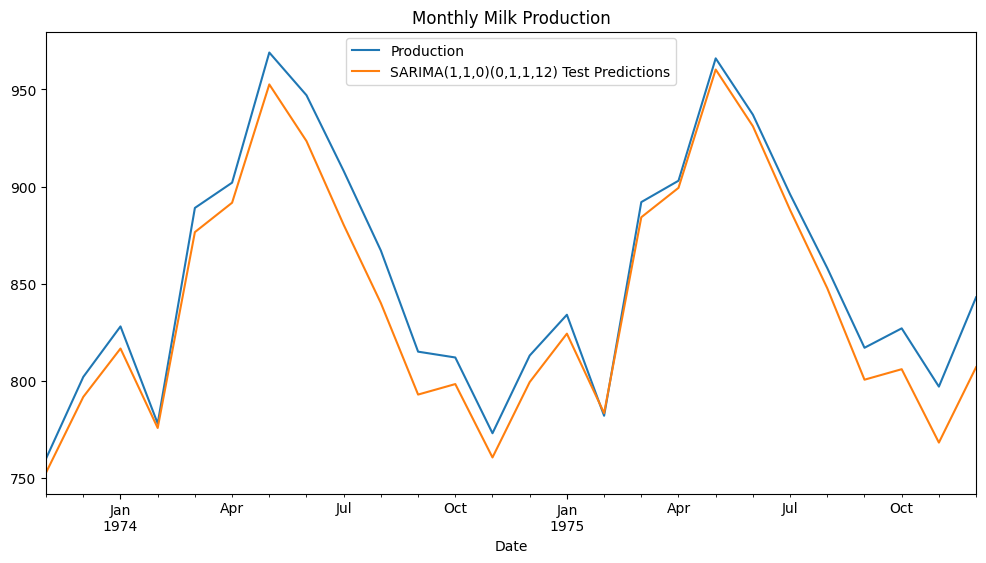

In [ ]:
title = 'Monthly Milk Production'
ax = test['Production'].plot(legend = True, figsize = (12,6), title = title)
predictions.plot(legend = True)
ax.autoscale(axis = 'x',tight = True)

On the basis of our test data, we use the SARIMAX model to make predictions, and we can see that the anticipated values come quite close to matching the test set's actual values.


In [ ]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Production'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Production'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Production'], predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Production'])/np.abs(test['Production']))*100

evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,0.924043,14.062889,274.940635,1.649905


Evaluation Metrics:

The model's R squared value is 0.92, which corresponds to a 92% coefficient of determination.
One of the most popular accuracy metrics, mean absolute percentage error (MAPE), expresses correctness as a percentage of error. The model's MAPE score is 1.64, meaning the forecast is 98.36% accurate but is off by 1.64%.


**Forecasting**

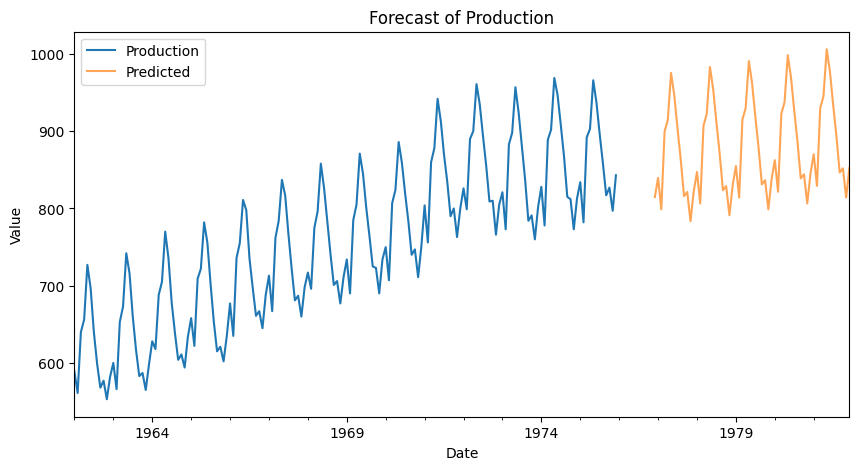

In [ ]:
forecast = results.get_prediction(start = '1976-12-01', end = '1981-12-01')
idx = np.arange(len(forecast.predicted_mean))

forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

fig, ax = plt.subplots()
df.plot(ax = ax, label='observed')
forecast_values.plot(ax = ax, label = 'Predicted', alpha = 0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
ax.set_title('Forecast of Production')
plt.show()